In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

!pip install metric-learn

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from metric_learn import MMC_Supervised

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 760.8 kB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = np.load('/content/drive/MyDrive/dml/indian-veriseti/indianpinearray.npy')

gt = np.load('/content/drive/MyDrive/dml/indian-veriseti/IPgt.npy')


def applyPCA(X, numComponents=15):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX


data=applyPCA(data)


df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df['class'] = gt.ravel()

X = df[df['class']!=0].iloc[:, :-1].values

y = df[df['class']!=0].iloc[:, -1].values

In [4]:


acc_list = []

kf = KFold(n_splits=5, shuffle=True,random_state=42)

mmc = MMC_Supervised(n_constraints=5,verbose=True)
knn = KNeighborsClassifier(n_neighbors=5)

f_index = 1
for train_index, test_index in kf.split(X):
    print(f"Fold {f_index} -> Train: {len(train_index)}, Test: {len(test_index)}")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    mmc.fit(X_train, y_train)
    knn.fit(mmc.transform(X_train), y_train)


    mmc_acc = knn.score(mmc.transform(X_test), y_test)
    print('mmc accuracy  {}'.format(mmc_acc))

    acc_list.append(mmc_acc)

    f_index += 1

print("Ortalaması Başarı:", np.mean(acc_list))
print("Standart sapma:",np.std(acc_list) )

Fold 1 -> Train: 8199, Test: 2050
mmc iter: 0, conv = 0.032194, projections = 514
mmc iter: 1, conv = 0.033335, projections = 2953
mmc iter: 2, conv = 0.034494, projections = 3166
mmc iter: 3, conv = 0.035652, projections = 3148
mmc iter: 4, conv = 0.036806, projections = 3138
mmc iter: 5, conv = 0.037949, projections = 3137
mmc iter: 6, conv = 0.039079, projections = 3145
mmc iter: 7, conv = 0.040191, projections = 3161
mmc iter: 8, conv = 0.041281, projections = 3186
mmc iter: 9, conv = 0.042346, projections = 3217
mmc iter: 10, conv = 0.043382, projections = 3254
mmc iter: 11, conv = 0.044385, projections = 3297
mmc iter: 12, conv = 0.045354, projections = 3345
mmc iter: 13, conv = 0.046286, projections = 3396
mmc iter: 14, conv = 0.047179, projections = 3451
mmc iter: 15, conv = 0.048031, projections = 3509
mmc iter: 16, conv = 0.048841, projections = 3570
mmc iter: 17, conv = 0.049609, projections = 3634
mmc iter: 18, conv = 0.050335, projections = 3701
mmc iter: 19, conv = 0.0510

In [5]:
import joblib

joblib.dump(mmc, 'mmc_indian_model.pkl')
joblib.dump(knn,'mmc_indian_knn_model.pkl')

mmc_loaded = joblib.load('mmc_indian_model.pkl')
knn_loaded =joblib.load('mmc_indian_knn_model.pkl')

mmc_data=mmc_loaded.transform(X)
pred=knn_loaded.predict(mmc_data)

In [6]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

print("accuracy:",accuracy_score(pred,y))
print("cohen kappa:", cohen_kappa_score(pred,y))
print("f1 score:",f1_score(pred,y,average='macro'))

accuracy: 0.7847594887306079
cohen kappa: 0.7536037127162359
f1 score: 0.7589801787430495


In [7]:
gt_2 = gt.copy()
gt_2=gt_2.reshape(-1)


i = 0
j=0
while(i<(gt.shape[0]*gt.shape[1])):
      if(gt_2[i] != 0):
          gt_2[i]=pred[j]
          j += 1
      i += 1

In [8]:
gt_2=gt_2.reshape(data.shape[0],-1)

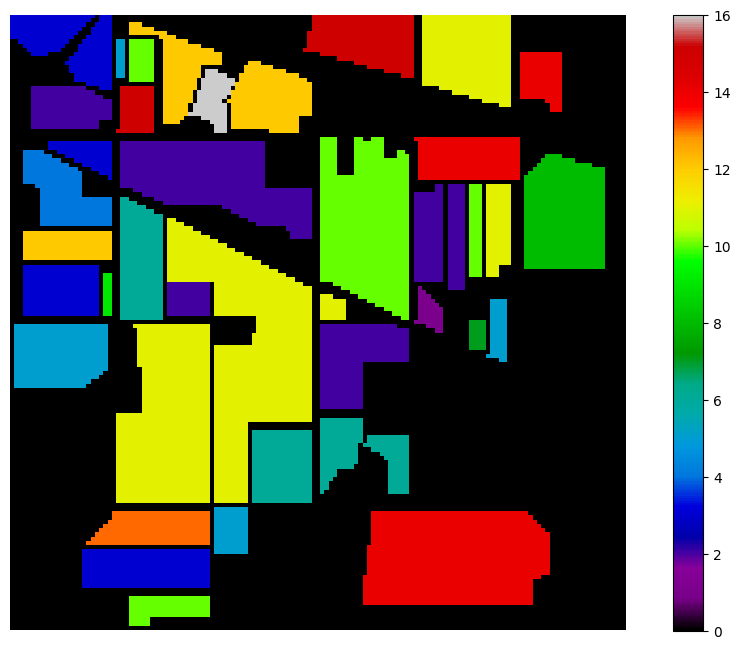

In [9]:
def plot_gt(data):
  fig = plt.figure(figsize=(12, 8))
  plt.imshow(data,cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_gt(gt)

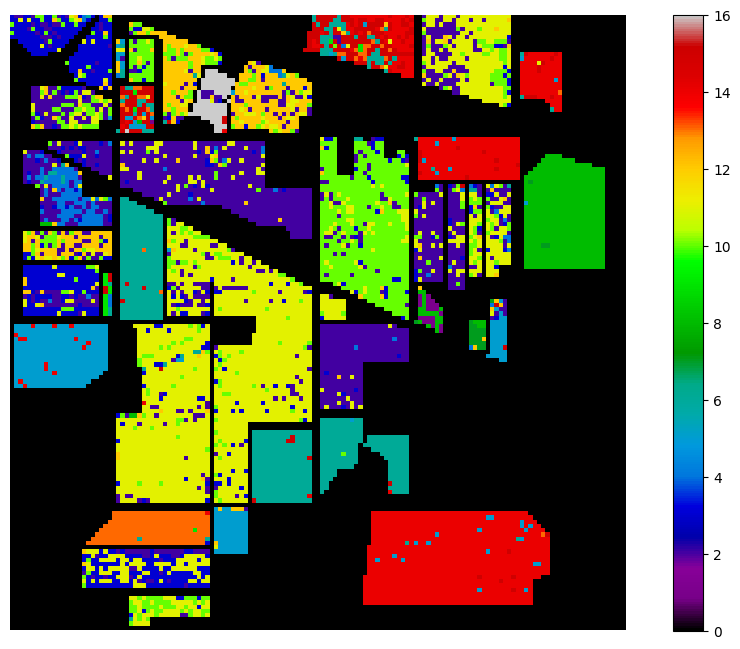

In [10]:
plot_gt(gt_2)